In [2]:
#Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import*

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import os
import pandas as pd
#from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model

2025-04-29 10:54:52.914267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745924093.202723      50 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745924093.280774      50 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:

import random


def set_seed(seed=52):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(52)

In [11]:
train_dir='/kaggle/input/kmc-liver/KMC_LiverGrading/Training'
test_dir='/kaggle/input/kmc-liver/KMC_LiverGrading/Test'
val_dir='/kaggle/input/kmc-liver/KMC_LiverGrading/Validation'

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # rotate images up to 20 degrees
    width_shift_range=0.1,       # shift horizontally
    height_shift_range=0.1,      # shift vertically
    zoom_range=0.2,              # random zoom
    shear_range=0.15,            # shear transformation
    horizontal_flip=True,        # flip images horizontally32
    fill_mode='nearest',# fill in missing pixels after transformation
    # featurewise_center=True,featurewise_std_normalization=True
)


In [13]:
# For Validation Data - Only rescaling (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# For Test Data - Only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)
# train data

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    # subset='training'
    shuffle = True
)

# Validation Data
val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=8,
    class_mode='categorical',
    # subset='validation',
    shuffle = False
)

#test data

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,

    class_mode='categorical',
    shuffle=False
)

Found 2549 images belonging to 4 classes.
Found 280 images belonging to 4 classes.
Found 280 images belonging to 4 classes.


In [14]:
#define multikernel block updated
def mk_block(input, num_filters):
    x1 = Conv2D(num_filters // 4 ,(1,1),padding = 'same')(input)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = SeparableConv2D(num_filters // 4 ,(3,3),padding = 'same')(input)# conv instead of separable conv
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2= Conv2D(num_filters // 4 ,(1,1),padding = 'same')(x2) # add 1x1 conv for dimensionality reduction

    x3 = SeparableConv2D(num_filters // 4 ,(5,5),padding = 'same')(input) # conv instead of separable conv
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)
    x3=Conv2D(num_filters // 4 ,(1,1),padding = 'same')(x3) # add 1x1 conv for dimensionality reduction

    x4 = SeparableConv2D(num_filters // 4 ,(7,7),padding = 'same')(input) # conv instead of separable conv
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)
    x4=Conv2D(num_filters // 4 ,(1,1),padding = 'same')(x4) # add 1x1 conv for dimensionality reduction
    x5=Conv2D(num_filters ,(1,1),padding = 'same')(input) # add 1x1 conv for dimensionality reduction
    x5=BatchNormalization()(x5)

    x = Concatenate()([x1,x2,x3,x4])
    x=Conv2D(num_filters ,(1,1),padding = 'same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Concatenate()([x,x5])
    x=Activation('relu')(x)

    return x

In [15]:
# RPAB

def RPAB_block(input,num_filters):
  x1=Conv2D(num_filters,kernel_size=(3,3),padding='same')(input)
  x1=BatchNormalization()(x1)


  x1=Activation('relu')(x1)
  x1=Conv2D(num_filters,kernel_size=(3,3),padding='same')(x1)
  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x1)

  x2=Activation('relu')(x2)

  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x2)
  x2=Activation('sigmoid')(x2)
  x2= Multiply()([x1,x2])
  x2= Add()([x2,input])
  return x2

In [16]:
# define RCAB
def RCAB_block(input,num_filters):
  x1=Conv2D(num_filters,kernel_size=(3,3),padding='same')(input)
  x1=Activation('relu')(x1)
  x1=Conv2D(num_filters,kernel_size=(3,3),padding='same')(x1)
  x2=GlobalAveragePooling2D()(x1)
  x2 = Reshape((1, 1, num_filters))(x2)
  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x2)
  x2=Activation('relu')(x2)
  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x2)
  x2=Activation('sigmoid')(x2)
  x2= Multiply()([x1,x2])
  input = Conv2D(num_filters, kernel_size=(1, 1), padding='same')(input) # add thisnew line
  x2=Add()([x2,input])
  return x2

In [17]:
# define mkrc +rpa+ rca
def mkrc_block(input,num_filters):
  x=mk_block(input,num_filters)
  x1=RCAB_block(x,num_filters)
  x2=RPAB_block(x1,num_filters)

  # x3=Concatenate()([x1,x2])
  x2=Conv2D(num_filters,kernel_size=(1,1),padding='same')(x2)
  x2=BatchNormalization()(x2)
  x2=Activation('relu')(x2)

  return x2


In [18]:
def SE_block(input,num_filters):

    x = GlobalAveragePooling2D()(input)

    x = Dense(num_filters // 16, activation='relu')(x) # Use input channels // 16

    x = Dense(num_filters, activation='sigmoid')(x)

    x = Reshape((1,1,num_filters))(x)

    x = Multiply()([input, x])
    return x

In [19]:
def rfb_block(input, num_filters):
    branch1 = Conv2D(num_filters, (1, 1), padding='same')(input)
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('relu')(branch1)


    branch2 = Conv2D(num_filters, (1, 1), padding='same', activation='relu')(input)
    branch2 = DepthwiseConv2D((3, 3), dilation_rate=2, padding='same')(branch2)
    branch2=BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)
    branch2= SE_block(branch2,num_filters)

    branch3 = Conv2D(num_filters, (1, 1), padding='same', activation='relu')(input)
    branch3 = DepthwiseConv2D((3, 3), dilation_rate=3, padding='same')(branch3)
    branch3=BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)
    branch3 = SE_block(branch3,num_filters)

    branch4 = Conv2D(num_filters, (1, 1), padding='same', activation='relu')(input)
    branch4 = DepthwiseConv2D((3, 3), dilation_rate=5, padding='same', activation='relu')(branch4)
    # branch4= Conv2D(num_filters, (1, 1), padding='same', activation='relu')(branch4)
    branch4 = SE_block(branch4,num_filters)
    x = Concatenate()([branch1, branch2, branch3, branch4])
    x = Conv2D(num_filters, (1, 1), padding='same', )(x)
    x= BatchNormalization()(x)
    x= Activation('relu')(x)

    return x

In [20]:
# define model
def ProposedModel(input_shape,classes = 4 ):
  X_input = Input(input_shape)


  x1=Conv2D(16,(3,3),padding='same',strides=(1,1))(X_input)
  x1=BatchNormalization()(x1)
  x1=Activation('relu')(x1)
  x1=Conv2D(16,(3,3),padding='same',strides=(1,1))(x1)
  x1=BatchNormalization()(x1)
  x1=Activation('relu')(x1)
  x=Conv2D(32,(3,3),padding='same',strides=(1,1))(x1)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  x1 = Conv2D(32, (1, 1), padding='same')(x1)
  x=Add()([x,x1])
  x=SE_block(x,32)
  x=MaxPooling2D((2,2))(x)



  # x2=SE_block(x1,32)
  x2= rfb_block(x,32) #instead of aspp
  # x2=SE_block(x2,32)
  x2= UpSampling2D((2,2), interpolation = 'bilinear')(x2)

  x3 = Conv2D(64,(3,3),padding='same',strides=(1,1))(x)
  x3 = BatchNormalization()(x3)
  x3 = Activation('relu')(x3)
  x3 = mkrc_block(x3,32)    #instead of cbam
  x3=Add()([x,x3])
  x3=SE_block(x3,32)


  x3 = MaxPooling2D((2,2))(x3)


  # x4=SE_block(x3,32)

  x4 = rfb_block(x3,32)
  # x4=SE_block(x4,32)
  x4 = UpSampling2D((4,4), interpolation = 'bilinear')(x4)

  x5 =Conv2D(64,(3,3),padding='same')(x3)
  x5 = BatchNormalization()(x5)
  x5 = Activation('relu')(x5)
  # add conv and res connection
  x5 = Conv2D(64,(1,1),padding='same')(x5)
  x3 = Conv2D(64, (1, 1), padding='same')(x3)
  x5 = Add()([x5,x3])
  x5 = Activation('relu')(x5)


  x5 = mkrc_block(x5,64)   # instead of cbam
  x5=SE_block(x5,64)
  x5 = MaxPooling2D((2,2))(x5)


  # x6=SE_block(x3,32)
  x6 = rfb_block(x5,64)  #instead of aspp
  # x6=SE_block(x6,64)
  x6 = UpSampling2D((8,8), interpolation = 'bilinear')(x6)


  x7= Concatenate()([x2,x4,x6])

  x7= GlobalAveragePooling2D()(x7)
  x7= Dense(256)(x7)
  x7= BatchNormalization()(x7)
  x7= Activation('relu')(x7)

  x7= Dropout(0.5)(x7)

  x7= Dense(128)(x7)
  x7= BatchNormalization()(x7)
  x7= Activation('relu')(x7)
  


  x7= Dense(classes)(x7)
  x7= Activation('softmax')(x7)

  model = Model(inputs=X_input,outputs=x7)
  return model

In [21]:


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from tensorflow.keras import regularizers
from tensorflow.keras.losses import CategoricalCrossentropy



model = ProposedModel((224,224,3),4)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])
model.summary()

set_seed(52)

I0000 00:00:1745924140.261687      50 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745924140.262419      50 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 224, 224, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 224, 224, 32)   │          4,640 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 224, 224, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 224, 224, 32)   │            544 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 32)   │              0 │ activation_2[0][0],    │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ add[0][0]              │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │             96 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 224, 224, 32)   │              0 │ add[0][0],             │
│                      

 Total params: 477,724 (1.82 MB)

 Trainable params: 474,588 (1.81 MB)

 Non-trainable params: 3,136 (12.25 KB)

In [22]:
model.save('Liver.h5')

In [51]:
#model.load_weights('/kaggle/input/weights/model_23_april_new.weights.h5')

In [15]:
# Reduce LR when accuracy plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode='max',  # Fix mode
                                                 factor=0.5,
                                                 patience=10,  # Reduce patience to make it adapt faster
                                                 verbose=1,
                                                 cooldown=1,
                                                 min_delta=0.0001,
                                                 min_lr=1e-6)  # Minimum LR limit

# Early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='max',
                                              min_delta=0.0001,
                                              patience=20,  # Reduced patience
                                              verbose=1,
                                              restore_best_weights=True)

# Model checkpoint for best weights
check_path = '/kaggle/working/model_29April_new_liver.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                mode='max')

# Train model with improved batch size
history = model.fit(train_data,
                    validation_data=val_data,
                    batch_size=8,
                    shuffle=True,
                    verbose=1,
                    epochs=100,
                    callbacks=[reduce_lr, early_stop, checkpoint])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745916594.611541     117 service.cc:148] XLA service 0x7ebf1c001800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745916594.613108     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745916594.613131     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745916599.855535     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745916634.350444     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.5941 - loss: 1.0071
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /kaggle/working/model_29April_new_liver.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 196s 317ms/step - accuracy: 0.5943 - loss: 1.0066 - val_accuracy: 0.2500 - val_loss: 2.0763 - learning_rate: 1.0000e-04
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7753 - loss: 0.6309
Epoch 2: val_accuracy improved from 0.25000 to 0.68571, saving model to /kaggle/working/model_29April_new_liver.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - accuracy: 0.7753 - loss: 0.6307 - val_accuracy: 0.6857 - val_loss: 0.8133 - learning_rate: 1.0000e-04
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7985 - loss: 0.5228
Epoch 3: val_accuracy improved from 0.68571 to 0.93214, saving model to /kaggle/working/model_29April_new_liver.weights.h5
319/319 ━━━━━━━━━━━━━━━━━━━━ 52s 159ms/step - accuracy: 0.7985 - loss: 0.5227 - va

In [25]:
#model evaluaion
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9889 - loss: 0.1129
Validation Loss: 0.15890969336032867
Validation Accuracy: 0.9750000238418579


In [26]:
class_names = list(test_data.class_indices.keys())
print(class_names)
test_predictions = model.predict(test_data)
test_pred = np.argmax(test_predictions, axis=1)
test_true =test_data.classes

['grade0', 'grade1', 'grade2', 'grade3']
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [29]:
# from sklearn.metrics import classification_report,confusion_matrix
# print("Performance Metrics: ")
# metrics = classification_report(test_true,test_pred,target_names=class_names)
# print(metrics)
# print("Confusion Matrix: ")
# CM = confusion_matrix(test_true, test_pred)
# print(CM)

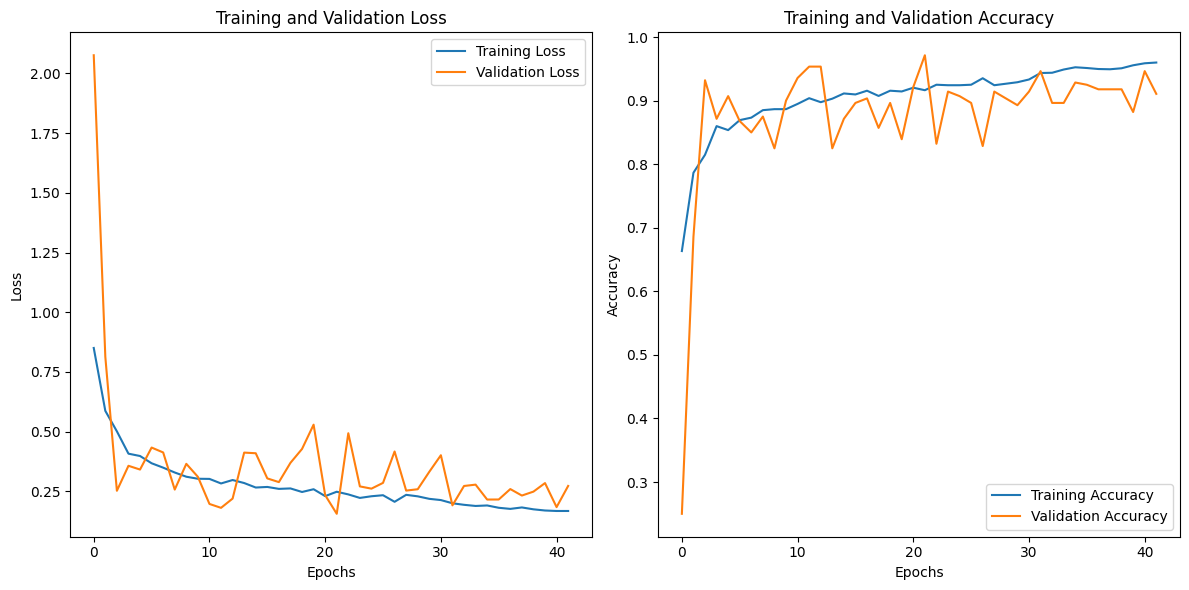

In [19]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [28]:
from tensorflow import keras

model = keras.models.load_model('/kaggle/working/Liver.h5')

In [29]:
model.load_weights('/kaggle/input/weights-on-liver-dataset/model_29April_new_liver.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 542 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [30]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation accuracy: {val_acc*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.9857 - loss: 0.1154
Validation accuracy: 97.86%


In [32]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')








import numpy as np

test_step = test_data.n//test_data.batch_size
test_data.reset()
pred = model.predict(test_data , steps = test_step , verbose = 1)

pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score,jaccard_score,classification_report
from sklearn.metrics import precision_score,recall_score,jaccard_score
classes = [0,1,2,3]

print(len(pred_class_indices))
print(len(test_data.labels))
for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_")


print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Found 280 images belonging to 4 classes.
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3]
280
280
class:  0
Accuracy 1.0
F1 1.0
precision 1.0
recall 1.0
jaccard 1.0
_
class:  1
Accuracy 0.9892857142857143
F1 0.9811320754716981
precision 0.9873417721518988
recall 0.975
jaccard 0.9629629629629629
_
class:  2
Accuracy 0.9857142857142858
F1 0.9753086419753086
precision 0.9634146341463414
recall 0.9875
jaccard 0.9518072289156626
_
class:  